In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config as cfg
import os
import pandas as pd
from utils import get_overview, open_gz, filter_district
import geopandas as gpd

In [86]:
mobility_data = cfg.MOBILITY_DATA
geometria_data = cfg.GEOMETRIA_DATA
zonificacion_data = cfg.ZONIFICACION_DATA
viajes_dir = cfg.VIAJES_DATA
vars_of_interest = cfg.INCOME_VARS_OF_INTEREST 
figures_path = cfg.FIGURES_PATH
outputs_path = cfg.OUTPUTS_PATH

In [87]:
rent_data = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson') # rent data to add to the viajes data to find income per district
rent_data = rent_data[['ID', 'geometry'] + vars_of_interest] # here I select the variables of interest
week = pd.read_csv(mobility_data / 'VIAJES/all_viajes_week_0222.csv') # week of interest
week = week.loc[(week['actividad_origen'] == 'casa')] # filtering only trips from home!

In [88]:
week.shape

(781697, 15)

## Assortativity Matrix

### 1. Adding income data per district to the mobility data, to later calculate deciles and build assortativity matrix

In [89]:
# Merge the two DataFrames based on the corresponding columns
viajes_with_income = pd.merge(
    week,
    rent_data,
    left_on='origen',  # The cleaned 'origen' from viajes DataFrame
    right_on='ID',  # The 'ID' from gdf
    how='left'  # Perform a left join to keep all rows from viajes
)

In [90]:
viajes_with_income.shape

(781697, 23)

### 2. Divide data into income deciles D for each SE class - for each origin and destination, I add the income decile 

In [91]:
var_of_interest = 'Renta bruta media por hogar'
 
# NOTE: I calculate the 'income' deciles based on a specific variable of interest. Maybe income is not the best naming.
rent_data['income_decile'] = pd.qcut(rent_data[var_of_interest], 10, labels=False)

viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='origen', right_on='ID', how='left', suffixes=('', '_origin'))

viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='destino', right_on='ID', how='left', suffixes=('', '_dest'))

viajes_with_income.drop(columns=['residencia', 'estudio_origen_posible', 'estudio_origen_posible', 'ID', 'ID_origin', 'ID_dest'], inplace=True)

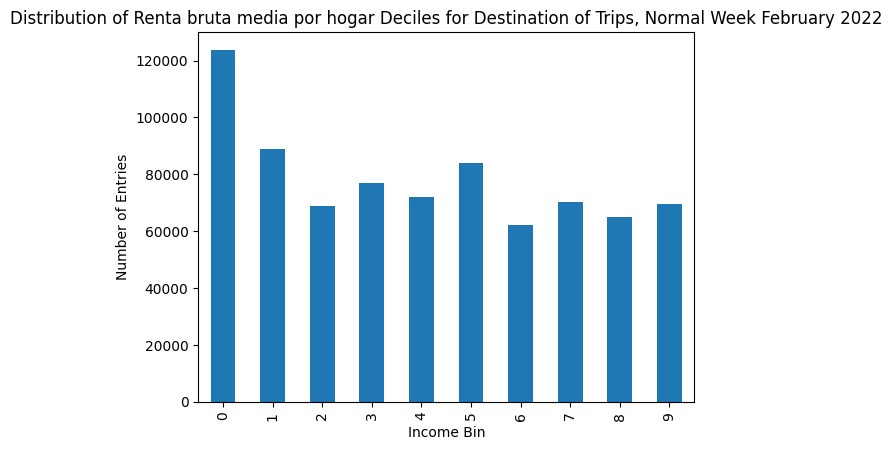

In [92]:
bin_counts = viajes_with_income['income_decile'].value_counts().sort_index()
bin_counts.plot(kind='bar')

plt.xlabel('Income Bin')
plt.ylabel('Number of Entries')
plt.title(f'Distribution of {var_of_interest} Deciles for Destination of Trips, Normal Week February 2022')

plt.savefig(figures_path / f'{var_of_interest}_deciles_distribution_destination.png', dpi=300, bbox_inches='tight')
plt.show()


### 3. For each decile and income from the mobility data (<10, 10-15, >15), count the number of trips between each origin-destination pair (ensure that this approach is correct)

In [93]:
# Group by origin and destination deciles and count the trips
trip_counts_by_decile = viajes_with_income.groupby(['renta', 'income_decile', 'income_decile_dest']).size().reset_index(name='trip_count')
districts = rent_data['ID'].unique()

### Build general matrix

In [94]:
# Assume districts is a list of the district names or IDs in Madrid
# N = len(viajes_with_income['income_decile'].unique())  
# A = np.zeros((N, N))  # Initialize an N x N matrix

In [95]:
trip_counts_by_decile.income_decile.value_counts()

income_decile
3    20
0    10
1    10
2    10
4    10
5    10
6    10
7    10
8    10
9    10
Name: count, dtype: int64

In [96]:
try:
    # Try using pivot() if there are no duplicate index/column combinations
    assortativity_matrix = trip_counts_by_decile.pivot(
        index='income_decile', 
        columns='income_decile_dest', 
        values='trip_count'
    ).fillna(0)

except ValueError as e:
    # If there's a ValueError (likely due to duplicate index/column pairs), fallback to pivot_table()
    print(f"Encountered an error with pivot(): {e}")
    print("Switching to pivot_table() to handle duplicates.")
    
    # Use pivot_table() with aggregation to handle duplicates
    assortativity_matrix = trip_counts_by_decile.pivot_table(
        index='income_decile', 
        columns='income_decile_dest', 
        values='trip_count', 
        aggfunc='sum',  # Aggregate duplicates by summing trip counts
        fill_value=0  # Fill missing values with 0
    )

# Continue with further processing or analysis of assortativity_matrix
print("Assortativity matrix created successfully.")

assortativity_matrix_normalized = assortativity_matrix.div(assortativity_matrix.sum(axis=1), axis=0)

Encountered an error with pivot(): Index contains duplicate entries, cannot reshape
Switching to pivot_table() to handle duplicates.
Assortativity matrix created successfully.


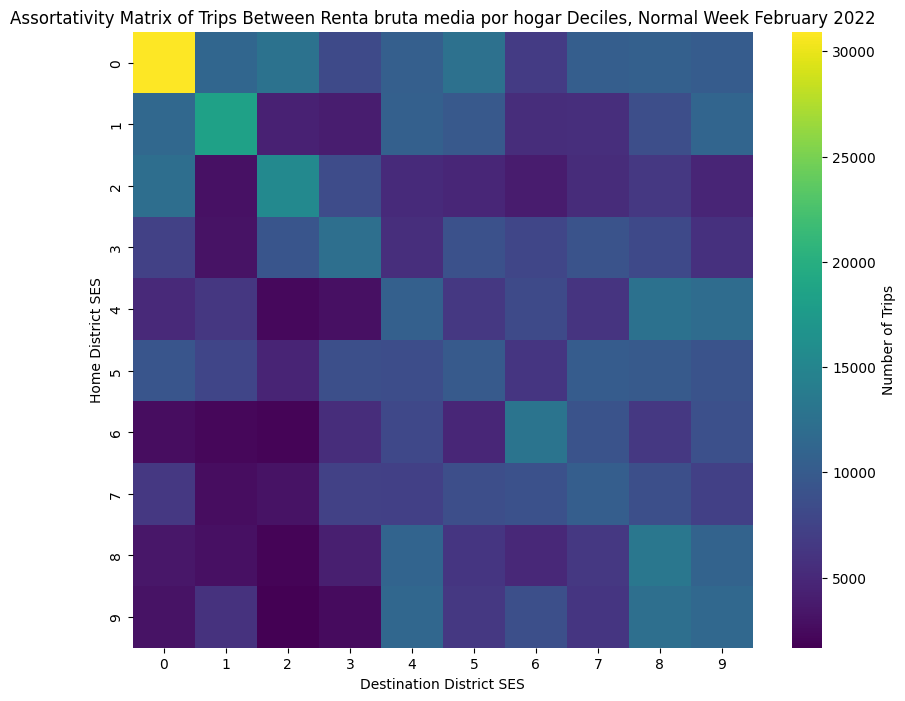

In [97]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix, annot=False, cmap='viridis', cbar_kws={'label': 'Number of Trips'}, fmt=".2f")
plt.title(f'Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

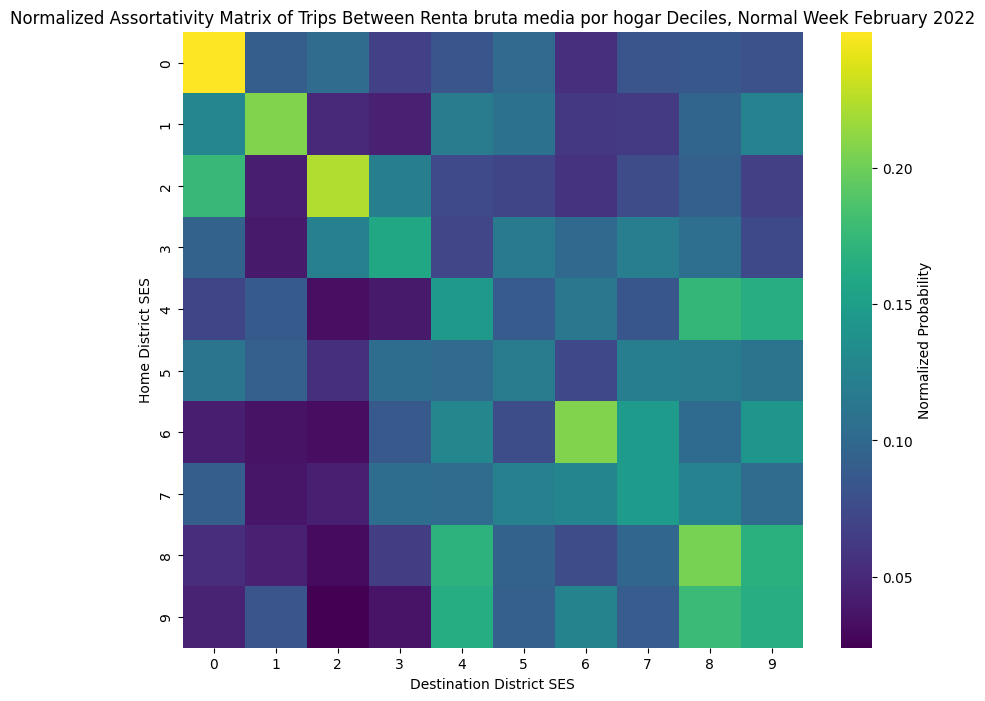

In [98]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title(f'Normalized Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()


In [99]:
for i in range(5):
    print(i, trip_counts_by_decile[trip_counts_by_decile['income_decile']==i].trip_count.mean())

0 12377.3
1 8891.2
2 6899.6
3 3855.05
4 7211.6


### Build matrix per income bracket (low-middle-high)

In [100]:
middle = trip_counts_by_decile[trip_counts_by_decile['renta']=='10-15']
high = trip_counts_by_decile[trip_counts_by_decile['renta']=='>15']

In [101]:
assortativity_matrix_middle = middle.pivot(index='income_decile', columns='income_decile_dest', values='trip_count').fillna(0)
assortativity_matrix_middle_normalized = assortativity_matrix_middle.div(assortativity_matrix_middle.sum(axis=1), axis=0)

assortativity_matrix_high = high.pivot(index='income_decile', columns='income_decile_dest', values='trip_count').fillna(0)
assortativity_matrix_high_normalized = assortativity_matrix_high.div(assortativity_matrix_high.sum(axis=1), axis=0)

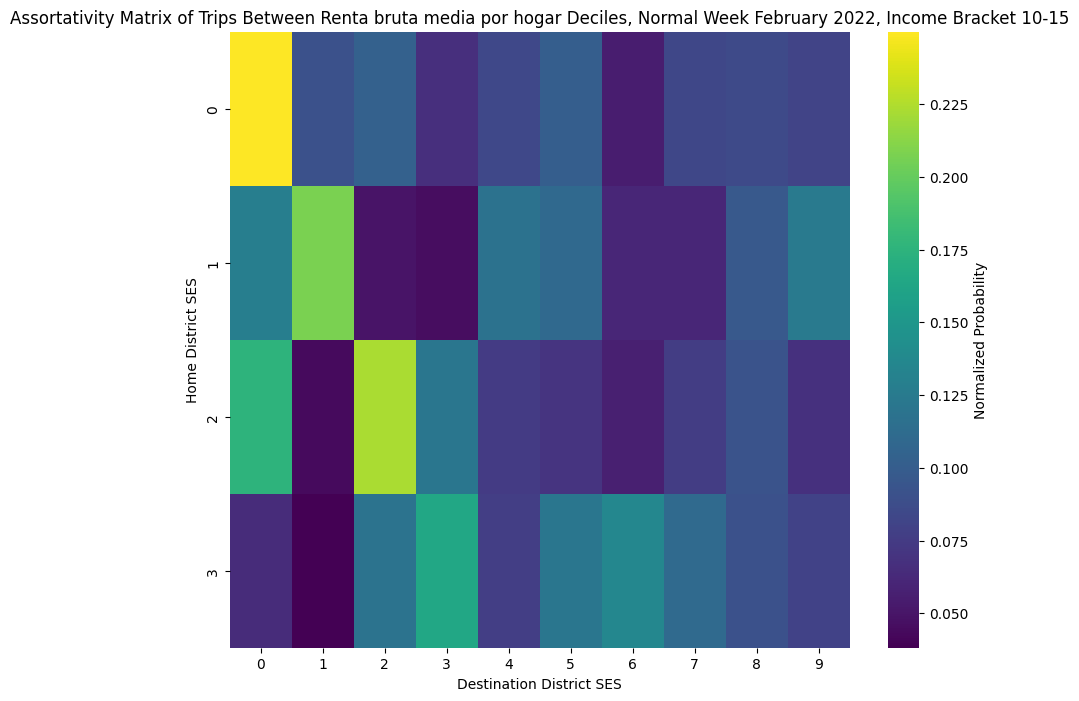

In [102]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_middle_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title(f'Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022, Income Bracket 10-15')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

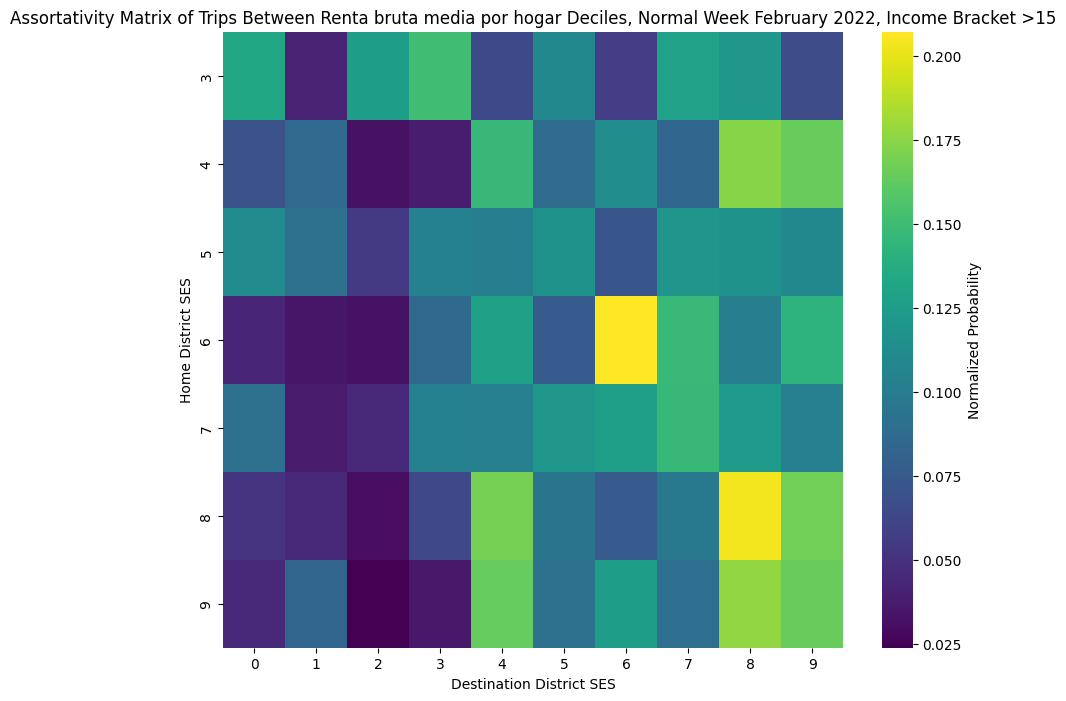

In [103]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_high_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title(f'Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022, Income Bracket >15')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

#### 4. Stratify by destination